# Multi-image super resolution with Transfer Learning

In [5]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
from scipy.io import loadmat
import os
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from utils.preprocessing import gen_sub, bicubic
from utils.loss import l1_loss, psnr, ssim
from utils.prediction import ensemble, unensemble, shuffle_last_axis, predict_tensor, predict_tensor_permute, savePredictions, savePredictionsPermut
from utils.network import RAMS
from utils.training import Trainer
from skimage import io
from zipfile import ZipFile
import random
import SimpleITK as sitk

In [6]:
PATH_DATASET = 'dataset' # pre-processed dataset path
name_net = 'RAMS' # name of the network
LR_SIZE = 128 # pathces dimension
SCALE = 3 # upscale of the proba-v dataset is 3
HR_SIZE = LR_SIZE * SCALE # upscale of the dataset is 3
OVERLAP = 32 # overlap between pathces
CLEAN_PATH_PX = 0.85 # percentage of clean pixels to accept a patch
band = 'RED' # choose the band for the training
checkpoint_dir = f'ckpt/{band}_{name_net}' # weights path
log_dir = 'logs' # tensorboard logs path
submission_dir = 'submission' # submission dir
name_zip = 'submission_RAMS.zip'
FILTERS = 32 # features map in the network
KERNEL_SIZE = 3 # convolutional kernel size dimension (either 3D and 2D)
CHANNELS = 9 # number of temporal steps
R = 8 # attention compression
N = 12 # number of residual feature attention blocks
lr = 1e-4 # learning rate (Nadam optimizer)
BATCH_SIZE = 32 # batch size
EPOCHS_N = 100 # number of epochs

In [11]:
rams_network = RAMS(scale=SCALE, filters=FILTERS, 
                 kernel_size=KERNEL_SIZE, channels=CHANNELS, r=R, N=N)
checkpoint = tf.train.Checkpoint(step=tf.Variable(0),
                                psnr=tf.Variable(1.0),
                                model=rams_network)
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [23]:
filename = '../anon_data/pat55_alldata.mat'
cancer_slice = 10

images = loadmat(filename)

_low_res_seq = images['data']
num_acq = _low_res_seq.shape[3]
low_res_seq = _low_res_seq[:,:,cancer_slice,:]
lor = np.expand_dims(low_res_seq, 0).astype('uint16')
lor = (lor)*256
img = predict_tensor(rams_network, lor[:,:,:,0:9])[0,:,:,0]

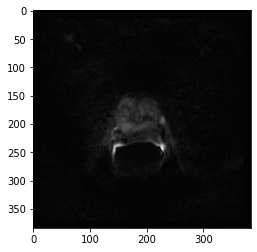

In [24]:
plt.imshow(img, cmap = 'gray')

def save_dicom(img, filename):
    expanded = np.expand_dims(img, 0).astype('int16')
    filtered_image = sitk.GetImageFromArray(expanded)
    writer = sitk.ImageFileWriter()
    for i in range(filtered_image.GetDepth()):
        image_slice = filtered_image[:,:,i]
        writer.SetFileName(filename)
        writer.Execute(image_slice)
fname = '../output_images/sr2_pt55_super.dcm'
save_dicom(img, fname)

In [4]:
#!pip install matplotlib
#!pip install scipy
#!pip install tqdm
#!conda install tensorflow-gpu
#!pip install --upgrade numpy
#!pip install opencv-python
#!pip install scikit-image
#!pip install tensorflow_addons
#!pip install SimpleITK

  Using cached SimpleITK-2.0.2-cp38-cp38-win_amd64.whl (25.6 MB)


In [ ]:








images_and_slices = [('pat47_XYZ_12_acq.mat', 12, 'Patient 47 slice 13'),\
                     ('pat07_XYZ_24_acquisitions.mat', 11, 'Patient 7 slice 12'),\
                     ('pat08_XYZ_23_acquisitions.mat', 10, 'Patient 8 slice 11') ]

for img_fname, _slice, desc in images_and_slices:


    low_res_seq = _low_res_seq[:,:,_slice,:]
    lor = np.expand_dims(low_res_seq, 0).astype('uint16')
    lor = (lor)*256
    #mean_pred = np.zeros((128*3, 128*3))
    mean_pred2 = np.zeros((128*3, 128*3))
#     for k in range(num_acq-10):
#         mean_pred += predict_tensor(rams_network, lor[:,:,:,k:9+k])[0,:,:,0]
    sample_size = 50
    for k in range(sample_size):
        inx = random.sample(list(range(num_acq)),9)
        inx_str = [str(x) for x in sorted(inx)]
        names = img_fname.split('_')
        fname = names[0] + '-' + '-'.join(inx_str) + '.dcm'
        img = predict_tensor(rams_network, lor[:,:,:,inx])[0,:,:,0]
        save_dicom2(img, fname)
        #mean_pred2 += predict_tensor(rams_network, lor[:,:,:,inx])[0,:,:,0]
#     mean_pred2 /= sample_size
#     mean_pred /= len(range(num_acq-10))
#     fig, ax = plt.subplots(1,4, figsize=(60,15))
#     ax[0].imshow(np.mean(low_res_seq, axis=-1), cmap ='gray')
#     ax[0].set_title('Mean image')    
#     ax[1].imshow(bicubic(np.mean(low_res_seq, axis=-1)[...,None])[0,:,:,0], cmap ='gray')
#     ax[1].set_title('Bicubic interpolation of the mean image')
#     ax[2].imshow(mean_pred, cmap = 'gray')
#     ax[2].set_title('Super resolution image')
#     ax[3].imshow(mean_pred2, cmap = 'gray')
#     ax[3].set_title('Super resolution image2')
#     fig.suptitle(desc)
#     plt.show()
#     save_dicom(bicubic(np.mean(low_res_seq, axis=-1)[...,None])[0,:,:,0], img_fname, 'LQ')
#     save_dicom(mean_pred, img_fname, 'HQ1')
#     save_dicom(mean_pred2, img_fname, 'HQ2')
    
    
    